In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
#Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Load the data
train_df = pd.read_csv('/kaggle/input/sales-data/train.csv')
test_df = pd.read_csv('/kaggle/input/sales-data/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (101490, 8)
Test shape: (2833, 7)


In [7]:
print(train_df.info())
print(train_df.describe())

# Missing values info
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          101490 non-null  object 
 1   date        101490 non-null  object 
 2   Item Id     101488 non-null  object 
 3   Item Name   99658 non-null   object 
 4   ad_spend    77303 non-null   float64
 5   anarix_id   101490 non-null  object 
 6   units       83592 non-null   float64
 7   unit_price  101490 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.2+ MB
None
           ad_spend         units     unit_price
count  77303.000000  83592.000000  101490.000000
mean     110.771470     10.284381     106.750922
std      529.303777     68.945915     425.704733
min        0.000000   -173.000000   -8232.000000
25%        0.000000      0.000000       0.000000
50%        4.230000      1.000000       0.000000
75%       44.310000      5.000000       0.000000
max    47934.990000  

In [8]:
def preprocess_data(df, is_train=True):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('Unknown')
        elif df[col].dtype.kind in 'iufc':  # integer, unsigned integer, float, complex
            df[col] = df[col].fillna(df[col].median())
            ##For numeric columns (integer, unsigned integer, float, complex), it fills missing values with the median of that column.
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in ['Item Name', 'anarix_id']:
        df[col] = le.fit_transform(df[col].astype(str))
    
    # Extract time-based features. This extracts year, month, day, and day of the week from the 'date' column, creating new features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # Calculate rolling statistics only for training data. The 7-day rolling mean provides a smoothed version of the 'units' data, helping to capture recent trends while reducing the impact of daily fluctuations.
    if is_train and 'units' in df.columns:
        df['rolling_mean_7d'] = df.groupby('Item Id')['units'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        df['rolling_std_7d'] = df.groupby('Item Id')['units'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
    
    return df

train_df = preprocess_data(train_df, is_train=True)
test_df = preprocess_data(test_df, is_train=False)

In [9]:
print(train_df.info())
print(train_df.describe())

# Missing values info
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               101490 non-null  object        
 1   date             101490 non-null  datetime64[ns]
 2   Item Id          101490 non-null  object        
 3   Item Name        101490 non-null  int64         
 4   ad_spend         101490 non-null  float64       
 5   anarix_id        101490 non-null  int64         
 6   units            101490 non-null  float64       
 7   unit_price       101490 non-null  float64       
 8   year             101490 non-null  int32         
 9   month            101490 non-null  int32         
 10  day              101490 non-null  int32         
 11  dayofweek        101490 non-null  int32         
 12  rolling_mean_7d  101490 non-null  float64       
 13  rolling_std_7d   101272 non-null  float64       
dtypes: datetime64[ns](1)

In [10]:
def engineer_features(df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    new_features = []

    # Ratio features
    if all(col in df.columns for col in ['unit_price', 'ad_spend']):
        df['price_to_adspend'] = df['unit_price'] / (df['ad_spend'] + 1e-5)  # Adding small value to avoid division by zero
        new_features.append('price_to_adspend')
    
    if all(col in df.columns for col in ['orderedrevenueamount', 'ad_spend']):
        df['revenue_to_adspend'] = df['orderedrevenueamount'] / (df['ad_spend'] + 1e-5)
        new_features.append('revenue_to_adspend')
    elif all(col in df.columns for col in ['units', 'unit_price', 'ad_spend']):
        df['revenue_to_adspend'] = (df['units'] * df['unit_price']) / (df['ad_spend'] + 1e-5)
        new_features.append('revenue_to_adspend')
    
    # Time-based features
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['dayofweek'] = df['date'].dt.dayofweek
        new_features.extend(['year', 'month', 'day', 'dayofweek'])
    
    # Rolling statistics (only if 'units' and 'Item Id' are present)
    if all(col in df.columns for col in ['units', 'Item Id']):
        df['rolling_mean_7d'] = df.groupby('Item Id')['units'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        df['rolling_std_7d'] = df.groupby('Item Id')['units'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
        new_features.extend(['rolling_mean_7d', 'rolling_std_7d'])
        
        # Lag features
        df['units_lag_1'] = df.groupby('Item Id')['units'].shift(1)
        df['units_lag_7'] = df.groupby('Item Id')['units'].shift(7)
        new_features.extend(['units_lag_1', 'units_lag_7'])
        
        # Difference features
        df['units_diff_1'] = df.groupby('Item Id')['units'].diff(1)
        df['units_diff_7'] = df.groupby('Item Id')['units'].diff(7)
        new_features.extend(['units_diff_1', 'units_diff_7'])
    
    print(f"New features created: {new_features}")
    return df



In [11]:
# Apply feature engineering to both train and test datasets
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Print out the columns in each dataset after feature engineering
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in test_df:", test_df.columns.tolist())

# Identify common columns between train and test datasets
common_columns = list(set(train_df.columns) & set(test_df.columns))
print("Common columns (potential features for modeling):", common_columns)

# If you need to select specific features for modeling, you can do so here
# For example:
modeling_features = [col for col in common_columns if col not in ['date', 'Item Name', 'units']]
print("Features selected for modeling:", modeling_features)

New features created: ['price_to_adspend', 'revenue_to_adspend', 'year', 'month', 'day', 'dayofweek', 'rolling_mean_7d', 'rolling_std_7d', 'units_lag_1', 'units_lag_7', 'units_diff_1', 'units_diff_7']
New features created: ['price_to_adspend', 'year', 'month', 'day', 'dayofweek']
Columns in train_df: ['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units', 'unit_price', 'year', 'month', 'day', 'dayofweek', 'rolling_mean_7d', 'rolling_std_7d', 'price_to_adspend', 'revenue_to_adspend', 'units_lag_1', 'units_lag_7', 'units_diff_1', 'units_diff_7']
Columns in test_df: ['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'unit_price', 'year', 'month', 'day', 'dayofweek', 'price_to_adspend']
Common columns (potential features for modeling): ['year', 'Item Id', 'ad_spend', 'ID', 'Item Name', 'dayofweek', 'date', 'day', 'month', 'price_to_adspend', 'unit_price', 'anarix_id']
Features selected for modeling: ['year', 'Item Id', 'ad_spend', 'ID', 'dayofweek', 'day', 'mo

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


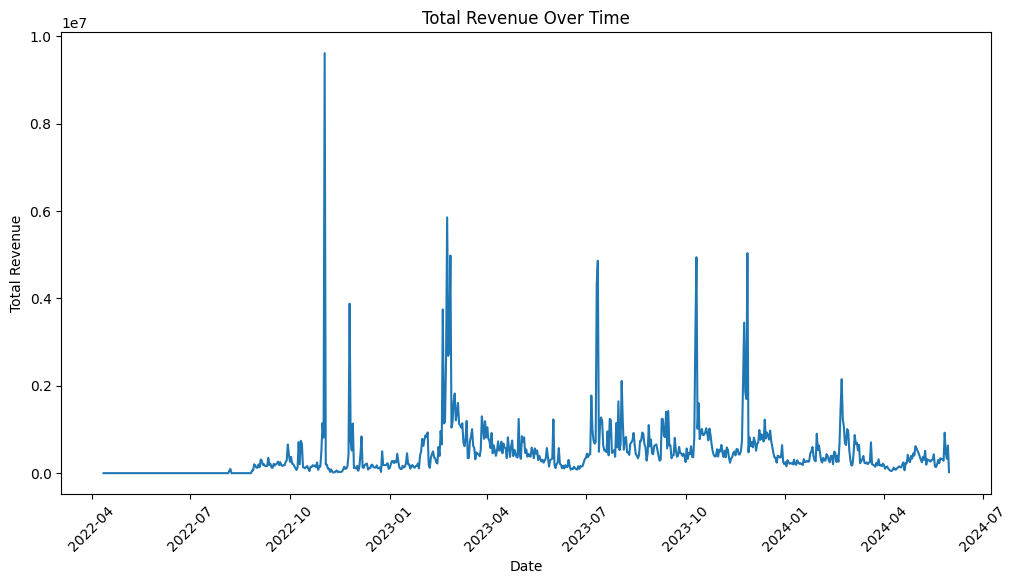

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def engineer_features(df):
    df = df.copy()
    
    # Ratio features
    df['price_to_adspend'] = df['unit_price'] / (df['ad_spend'] + 1e-5)
    
    # Time-based features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # Calculate total revenue if possible
    if 'orderedrevenueamount' in df.columns:
        df['total_revenue'] = df['orderedrevenueamount']
    elif 'units' in df.columns and 'unit_price' in df.columns:
        df['total_revenue'] = df['units'] * df['unit_price']
    else:
        print("Warning: Unable to calculate total revenue. Required columns not found.")
    
    # Rolling statistics and lag features (only if 'units' is present)
    if 'units' in df.columns:
        df['rolling_mean_7d'] = df.groupby('Item Id')['units'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        df['units_lag_7'] = df.groupby('Item Id')['units'].shift(7)
    
    return df

# Apply feature engineering
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Identify common columns
common_columns = list(set(train_df.columns) & set(test_df.columns))
modeling_features = [col for col in common_columns if col not in ['date', 'Item Name', 'units']]

# Time Series Analysis: Total Revenue Over Time
if 'total_revenue' in train_df.columns:
    plt.figure(figsize=(12, 6))
    train_df_grouped = train_df.groupby('date')['total_revenue'].sum().reset_index()
    sns.lineplot(data=train_df_grouped, x='date', y='total_revenue')
    plt.title('Total Revenue Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45)
    plt.show()




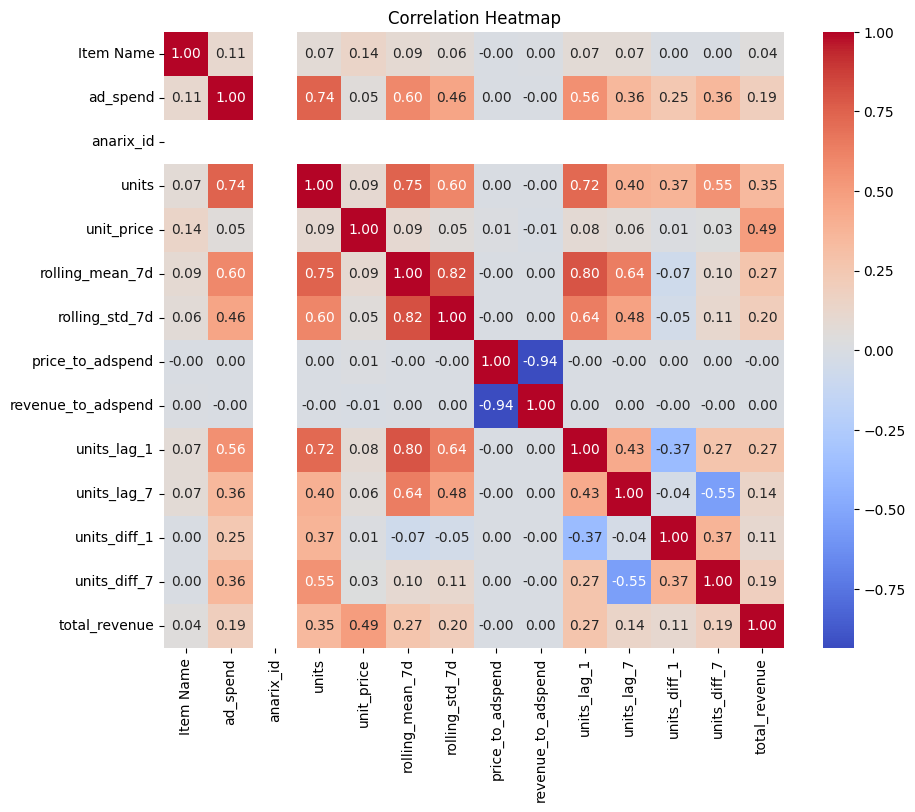

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_columns = train_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_columns.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The variables units and ad_spend have the strongest correlation (0.60), suggesting that marketing efforts have a significant impact on sales volume. total_revenue is moderately influenced by both units and unit_price, indicating that revenue is a function of both the quantity sold and the pricing strategy. Understanding these correlations helps identify which factors are most closely associated with sales performance and revenue, allowing for more informed decision-making in marketing and pricing strategies.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
# Define categorical and numerical features
cat_features = ['Item Id', 'anarix_id']
num_features = ['dayofweek', 'unit_price', 'price_to_adspend', 'day', 'year', 'ad_spend', 'month']

# One-hot encode categorical features
train_encoded = pd.get_dummies(train_df, columns=cat_features, prefix=cat_features)
test_encoded = pd.get_dummies(test_df, columns=cat_features, prefix=cat_features)

# Ensure train and test have the same columns
common_columns = train_encoded.columns.intersection(test_encoded.columns)
train_encoded = train_encoded[common_columns]
test_encoded = test_encoded[common_columns]

# Prepare features and target
features = num_features + [col for col in train_encoded.columns if col.startswith(tuple(cat_features))]
X = train_encoded[features]
y = train_df['units']

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Lists to store cross-validation results
cv_scores = []

# Train the model with cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    
    # Predict on validation set
    val_pred = model.predict(X_val)
    
    # Calculate MSE for this fold
    mse = mean_squared_error(y_val, val_pred)
    cv_scores.append(mse)
    
    print(f"Fold {fold} - MSE: {mse}")

# Print average cross-validation score
print(f"Average MSE across all folds: {np.mean(cv_scores)}")

# Retrain on full training data
model.fit(X, y)

# Make predictions on test set
X_test = test_encoded[features]
predictions = model.predict(X_test)

# Prepare submission
submission = pd.DataFrame({
    'date': test_df['date'],
    'Item Id': test_df['Item Id'],
    'units': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

Fold 1 - MSE: 1240.8905738976664
Fold 2 - MSE: 10405.035103455428
Fold 3 - MSE: 950.3526184184071
Fold 4 - MSE: 2950.0768024860995
Fold 5 - MSE: 614.3138310092289
Average MSE across all folds: 3232.1337858533657
Submission file created: submission.csv

Top 10 most important features:
               feature  importance
5             ad_spend    0.676773
1           unit_price    0.102307
3                  day    0.044363
6                month    0.036497
75  Item Id_B0BGDWGRQB    0.027718
2     price_to_adspend    0.018758
22  Item Id_B09KT5HMNY    0.017475
4                 year    0.016726
0            dayofweek    0.016574
34  Item Id_B09MR4B13C    0.011018


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

# Define the hyperparameter space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9)
}

# Create a base model
rf = RandomForestRegressor(random_state=69)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=69,
    verbose=2
)

# Perform the random search
random_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)

# Use the best model for predictions
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

# Prepare submission with the best model
submission = pd.DataFrame({
    'date': test_df['date'],
    'Item Id': test_df['Item Id'],
    'units': predictions
})
submission.to_csv('submission_tuned.csv', index=False)
print("Tuned submission file created: submission_tuned.csv")

# Feature importance for the best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 most important features (tuned model):")
print(feature_importance.head(10))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 